# content
1. 일자별 신규 & 누적 확진자수 확인 ( 전국 )
  - 1.1. 일별 확진자수를 기존 데이터에 추가 
  - 1.2. 일자별 신규 & 누적 확진자수 
  - 1.3. 지역별 확진자수 분포  
  - 1.4. 성별/ 나이대별 확진자수
2. 연령별 누적 확진자 및 사망자 분석
  - 연령별 누적 확진자수 및 누적 사망자수 
3. 감염 이유 분석
4. 확진자수 기준으로 위험군 선정 
  - 기존의 확진자 데이터 기준으로 위험군 선정
  - 예측된 확진자 데이터 기준으로 위험군 선정 

In [1]:
# module import 
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
import folium
from folium import plugins
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from IPython.display import display, Image
#from selenium import webdriver
#from selenium.common.exceptions import NoSuchElementException,StaleElementReferenceException
import json
import time
warnings.filterwarnings(action='ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning) 

%matplotlib inline
plt.style.use('seaborn')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.io as pio
pio.renderers.default = 'colab'
from plotly.offline import init_notebook_mode, iplot

In [3]:
#!pip install plotly

In [4]:
pd.set_option('max_columns', 24,'max_rows', 20) 
plt.style.use('seaborn')
plt.rc('font', family='Malgun Gothic') 
plt.rc('axes', unicode_minus=False)

In [5]:
#그래프 한글 출력을 위한 코드
#!sudo apt-get install -y fonts-nanum
#!sudo fc-cache -fv
#!rm ~/.cache/matplotlib -rf
#!pip install git+https://github.com/python-visualization/branca.git@master

# 1. 일자별 신규 & 누적 확진자수 ( 전국 )
### 1.1. 일별 확진자수를 기존 데이터에 추가 

In [6]:
def make_daily(df):
    daily = df.sort_values(['date'], ascending = False)
    daily = daily.reset_index()
    daily = daily.drop(['index'],axis=1)
    
    only_case = []

    for i in range(len(daily)-1):
        only_case.append(daily['confirmed'][i]-daily['confirmed'][i+1])
    only_case.append(1)

    daily['daily'] = only_case

    daily = daily.sort_values(['date'],ascending=True)
    daily = daily.reset_index()
    daily = daily.drop(['index'],axis=1)
    
    return daily

In [7]:
# date(날짜), confirmed(누적확진자수) 기준 데이터셋 생성
time = pd.read_csv('Time.csv', usecols = ['date', 'confirmed'])

# 해당 데이터셋에 일별 확진자수 추가 
time = make_daily(time)

In [8]:
fig = go.Figure()
fig.add_trace(go.Line(x=time['date'], y = time['confirmed'], name = "일자별 누적 확진자 수(전국)", marker_color='#009770', yaxis="y"))
fig.add_trace(go.Bar(x=time['date'], y = time['daily'], name = "일자별 확진자 수(전국)", marker_color='#E91E63', yaxis="y2"))
fig.update_layout(shapes=[dict(fillcolor="rgba(211, 211, 211, 0.3)",line={"width": 0}, type="rect",x0="2020-02-25",x1="2020-03-09",xref="x",y0=0,y1=0.95,yref="paper")])
fig.update_layout(xaxis=dict(rangeslider=dict(autorange=True, range=["2020-01-20", "2020-06-30"],visible=True),type="date"),
                  yaxis=dict(anchor="x",autorange=True,domain=[0, 0.5],linecolor="#009770",mirror=True,range=[-60.0858369099, 28.4406294707],showline=True,side="right",
                             tickfont={"color": "#009770"},tickmode="auto",ticks="",titlefont={"color": "#009770"},type="linear",zeroline=False),
                  yaxis2=dict(anchor="x",autorange=True,domain=[0.5, 0.95],linecolor="#E91E63",mirror=True,range=[29.3787777032, 100.621222297],showline=True,side="right",
                             tickfont={"color": "#E91E63"},tickmode="auto",ticks="",titlefont={"color": "#E91E63"},type="linear",zeroline=False))
fig.update_layout(dragmode="zoom", hovermode="x", height=700, template="plotly_dark", title_text = "일자별 코로나 확진 현황", margin=dict(t=100, b=100))

fig.show()

2020년 6월 30일 까지의 코로나 데이터를 집계한 결과, 이전 3월에 가장 많은 확진자가 나왓음을 확인할 수 있고, 잠잠하다 다시 2020년 6월부터 다시 재개 되었음을 확인할 수 있었음.  

### 1.2. 일자별 신규 & 누적 확진자수 
#### 1.2.1. 코로나19 확진자 map

In [9]:
# 각 지역별 확진자 확인 
case = pd.read_csv('Case.csv')
pv_sum = case.filter(['province', 'confirmed']). groupby(['province']).sum()

In [10]:
pv_sum['lat'] = 0.0
pv_sum['lon'] = 0.0

In [11]:
# 각 지역별 위경도 표시 (각 지역별 확진자 표기하기 위함)
#지역별 위도,경도 추가
pv_sum.loc['강원도','lat'] = 38.079
pv_sum.loc['강원도','lon'] = 128.284
pv_sum.loc['경기도','lat'] = 37.194
pv_sum.loc['경기도','lon'] = 127.255
pv_sum.loc['경상남도','lat'] = 35.295
pv_sum.loc['경상남도','lon'] = 128.389
pv_sum.loc['경상북도','lat'] = 36.652
pv_sum.loc['경상북도','lon'] = 128.828
pv_sum.loc['광주','lat'] = 35.128
pv_sum.loc['광주','lon'] = 126.850
pv_sum.loc['대구','lat'] = 35.826
pv_sum.loc['대구','lon'] = 128.527
pv_sum.loc['대전','lat'] = 36.263
pv_sum.loc['대전','lon'] = 127.404
pv_sum.loc['부산','lat'] = 35.160
pv_sum.loc['부산','lon'] = 129.113
pv_sum.loc['서울','lat'] = 37.590
pv_sum.loc['서울','lon'] = 127.002
pv_sum.loc['세종','lat'] = 36.551
pv_sum.loc['세종','lon'] = 127.303
pv_sum.loc['울산','lat'] = 35.516
pv_sum.loc['울산','lon'] = 129.322
pv_sum.loc['인천','lat'] = 37.484
pv_sum.loc['인천','lon'] = 126.652
pv_sum.loc['제주도','lat'] = 33.507
pv_sum.loc['제주도','lon'] = 126.525
pv_sum.loc['전라남도','lat'] =  34.694
pv_sum.loc['전라남도','lon'] = 126.976
pv_sum.loc['전라북도','lat'] =  35.774
pv_sum.loc['전라북도','lon'] = 127.099
pv_sum.loc['충청남도','lat'] = 36.566
pv_sum.loc['충청남도','lon'] = 126.617
pv_sum.loc['충청북도','lat'] = 36.756
pv_sum.loc['충청북도','lon'] = 127.602

In [12]:
# folium 시각화
m = folium.Map([36.4, 128], zoom_start = 7)

for index, row in pv_sum.iterrows():
    folium.Circle(
        location = (row['lat'],row['lon']), 
        fill_color='#ff3399',
        color = '#E91E63',
        radius = row['confirmed']*12
    ).add_to(m)
m

지역국한이 아니라 전국 지역의 확진자를 확인이 가능하다. 

### 1.2.2. 지역별 확진자수 분포

In [13]:
pv_sum = case.filter(['province', 'confirmed']).groupby(['province']).sum().reset_index()
data = [go.Pie(labels=pv_sum['province'], values=pv_sum['confirmed'],hole=.3)]
fig = go.Figure(data=data)
fig.update_layout(
    title={'text': "지역별 확진자 수", 'y':0.9,'x':0.5,'xanchor': 'center','yanchor': 'top'})
fig.update_layout(template='plotly_dark')
fig.update_traces(textposition='inside')
pyo.iplot(fig)

bar plot을 확인하면 대구, 서울, 경북, 경기 순으로 코로나 확진자가 있음을 확인할 수 있다. 대구는 신천지 집단 감염 사태로 인해 확진자가 폭증했는데 이와 인접한 결과이다. 대구 경북 지역을 제외하면 수도권 지역이 가장 많다. 

### 1.3. 성별 / 나이대별 확진자수 

In [14]:
patientinfo = pd.read_csv('PatientInfo.csv')
patientinfo = patientinfo.dropna(subset = ['sex', 'age']) #결측치 제거
patientinfo.sort_values(by=['age'], axis=0,inplace=True)

In [15]:
fig = px.histogram(patientinfo, x="age", color="sex", color_discrete_sequence = ['blue', '#E91E63'], marginal = 'violin')
fig.update_layout(barmode='stack')
fig.update_layout(template = 'plotly_dark')
fig.show()

위 barplot을 확인하면 20대의 확진자 비율이 가장 높음을 확인할 수 있다. 이는 20대가 10대보다 비교적 활동하는 반경이 없고 30대보다 비교적 여유시간을 더 가진다는 점에서 나온 결과임을 알 수가 있다. 

# 2. 연령별 누적 확진자 및 사망자 분석 

In [16]:
# 데이터 불러오기 : covid_TimeAge.csv
covid_TimeAge = pd.read_csv('TimeAge.csv')

# 컬럼명 변경 : 테이블 정의서 참고
covid_TimeAge.columns = ['날짜','시간','환자의 나이','누적 확진자 수','누적 사망자 수']

# 불필요한 컬럼 제거
covid_TimeAge.drop(['시간'], axis=1, inplace=True)

covid_TimeAge.head()

,날짜,환자의 나이,누적 확진자 수,누적 사망자 수
0,2020-03-02,0s,32,0
1,2020-03-02,10s,169,0
2,2020-03-02,20s,1235,0
3,2020-03-02,30s,506,1
4,2020-03-02,40s,633,1


In [17]:
# 마지막 집계일(2020.06.30)만 추출
total_0630 = covid_TimeAge[covid_TimeAge['날짜']=='2020-06-30']

# 연령대별 치료일수 비교
# 나이 중 숫자만 비교하기 위해 추출
total_0630['나이_int'] = total_0630['환자의 나이'].apply(lambda x : x[:-1]).astype('int')

## Age_Group 추가
def age(x):
    if x <= 10 : return '미성년자'
    elif x <= 30: return '청년층'
    elif x <= 50 : return '중년층'
    else: return '고령층'
        
total_0630['연령층'] = total_0630['나이_int'].apply(age)

# 컬럼 추가
total_0630['누적 확진자 수 비율'] = round(total_0630['누적 확진자 수']/(total_0630['누적 확진자 수'].sum()) * 100,2)
total_0630['누적 사망자 수 비율'] = round(total_0630['누적 사망자 수']/(total_0630['누적 사망자 수'].sum()) * 100,2)

total_0630.head()

,날짜,환자의 나이,누적 확진자 수,누적 사망자 수,나이_int,연령층,누적 확진자 수 비율,누적 사망자 수 비율
1080,2020-06-30,0s,193,0,0,미성년자,1.51,0.00
1081,2020-06-30,10s,708,0,10,미성년자,5.53,0.00
1082,2020-06-30,20s,3362,0,20,청년층,26.27,0.00
1083,2020-06-30,30s,1496,2,30,청년층,11.69,0.71
1084,2020-06-30,40s,1681,3,40,중년층,13.13,1.06


### 연령별 누적 확진자 수 및 누적 사망자수 

In [18]:
# line charts : 연령별 누적 확진자 수 추이 그래프
fig = px.bar(covid_TimeAge, x='날짜', y='누적 확진자 수', 
             color = "환자의 나이", color_discrete_sequence = px.colors.qualitative.Pastel)

fig.update_layout(title='<b>연령별 누적 확진자 수 추이</b>', 
                  plot_bgcolor="#FFFFFF",yaxis_gridcolor = '#D5D5D5')

fig.show()

In [19]:
# pie chart :연령별 확진자 비중
fig = px.pie(total_0630, names='연령층' ,values='누적 확진자 수', 
             title='<b>연령별 확진자 수(2020.06.30)</b>',
             color_discrete_sequence = px.colors.colorbrewer.Set2)
                
fig.update_traces(textinfo='percent+label', textfont_size=13, hole=.3)

fig.show()

In [20]:
# line charts :연령별 누적 확진자 수 추이 그래프
fig = px.bar(covid_TimeAge, x='날짜', y='누적 사망자 수', 
             color = "환자의 나이", color_discrete_sequence = px.colors.qualitative.Pastel)

fig.update_layout(title='<b>연령별 누적 사망자 수 추이</b>', 
                  plot_bgcolor="#FFFFFF", yaxis_gridcolor = '#D5D5D5')

fig.show()

In [21]:
# pie chart : 연령별 사망자 비중
fig = px.pie(total_0630, names='연령층' ,values='누적 사망자 수',
             title='<b>연령별 사망자 수 (2020.06.30)</b>',
             color_discrete_sequence = px.colors.colorbrewer.Set2)
                
fig.update_traces(textinfo='percent+label', textfont_size=13, hole=.3)

fig.show()

위의 결과를 확인하면 2020년 6월 30일을 기준으로 연령별 확진자수는 청년층 38%, 중년층 31%, 고령층 24%, 미성년자 7% 순서이다. 반면 6월 30일 기준으로 사망자수를 확인하면 고령층이 압도적임. 즉 고령층은 다른 연령보다 코로나가 생사에 더 치명적이다. 특히나 추석은 고령층과 장년층/청년층이 만날 확률이 높은 시기이므로 가장 조심해야할 때로 확인이 가능하다. 


# 3. 감염 이유 분석

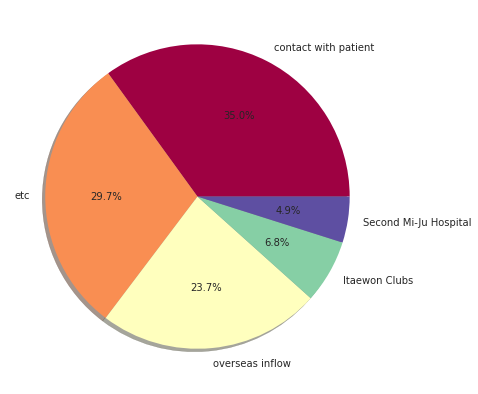

In [87]:
# 그래픽 크기 설정
plt.rcParams["figure.figsize"] = (15, 7)

# 집단 감염 사례 상위 6개 확인
groupcase = case_data.filter(['infection_case', 'confirmed'])
groupcase_tmp = groupcase.groupby(['infection_case']).sum()

groupcase_top6 = groupcase_tmp.sort_values('confirmed',ascending=False).head(6)

# 신천지 사례는 이미 독보적이므로 그를 제외한 다섯 가지 사례에 대한 pie chart 생성
groupcase_top = groupcase_top6.iloc[1:7,:]

c_map = plt.get_cmap('Spectral')
col = [c_map(i) for i in np.linspace(0, 1, 5)]

#plt.title("집단 감염 사례 2위 - 6위")
plt.pie(groupcase_top.confirmed, labels=list(groupcase_top.index), autopct='%1.1f%%', shadow=True, colors=col)
plt.show()

감염이유를 확인해보면, 해외유입을 제외하면 대부분 집단감염이 가장 큰 원인이 되었음을 확인할 수 있음. 따라서 다가오는 추석이 집단 감염으로 COVID-19가 전파될 위험이 큼을 확인할 수 있었음. 

In [89]:
# 시,도 단위로 데이터 분할 저장
state_data = case_data.filter(['province', 'confirmed'])
state_data = state_data.groupby(['province'], as_index=False).sum()
state_data

,province,confirmed
0,강원도,62
1,경기도,1000
2,경상남도,132
3,경상북도,1324
4,광주,43
5,대구,6680
6,대전,131
7,부산,156
8,서울,1280
9,세종,49


# 4. 예측된 확진자수 기준으로 위험군 선정 
- 기존의 확진자수 데이터를 기준으로 위험군 선정
- 확진자수 예측 결과를 통해 위험군 선정 

### 4.1. 기존의 확진자수 데이터 기준으로 위험군 선정 

In [22]:
province = pd.read_csv('TimeProvince.csv')

In [23]:
province.tail() # 2020 01 ~ 2020 06  데이터 사용 

,date,time,province,confirmed,released,deceased
2766,2020-06-30,0,전라북도,27,21,0
2767,2020-06-30,0,전라남도,24,19,0
2768,2020-06-30,0,경상북도,1389,1328,54
2769,2020-06-30,0,경상남도,134,128,0
2770,2020-06-30,0,제주도,19,16,0


In [24]:
print(province.shape)

(2771, 6)


In [25]:
province_sum = province.groupby(['date', 'province'])
province_sum[['date', 'province', 'confirmed']].head()

,date,province,confirmed
0,2020-01-20,서울,0
1,2020-01-20,부산,0
2,2020-01-20,대구,0
3,2020-01-20,인천,1
4,2020-01-20,광주,0
...,...,...,...
2766,2020-06-30,전라북도,27
2767,2020-06-30,전라남도,24
2768,2020-06-30,경상북도,1389
2769,2020-06-30,경상남도,134


No handles with labels found to put in legend.


findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


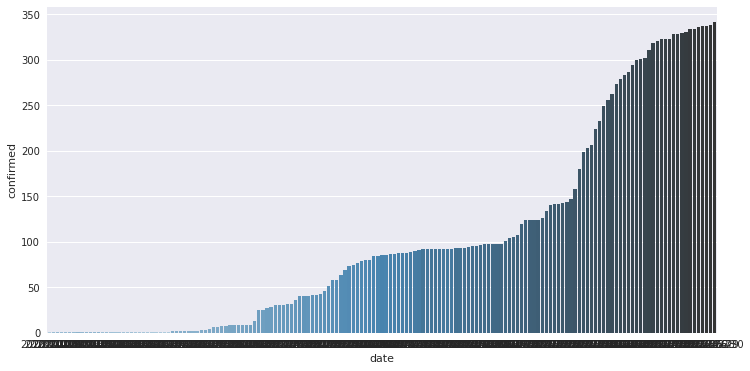

In [26]:
plt.figure(figsize=(12,6))
sample_data = province[province['province']== "인천"] # 경상북도에서의 확진자수 변화 확인  
pal = sns.color_palette("Blues_d", sample_data.shape[0]) 
rank = sample_data['confirmed'].argsort().argsort() # 이용량에 따라 색을 다르게해 시각화된 이미지의 직관성을 높입니다.
sns.barplot(x="date",y="confirmed",data=sample_data,palette=np.array(pal[::-1])[rank]) 
# plt.axvline(5.5,color='red',label='COIVD-19 era',linewidth=1)
#plt.axvspan(5.5, 9.5, color='red', alpha=0.2)
plt.legend()

No handles with labels found to put in legend.


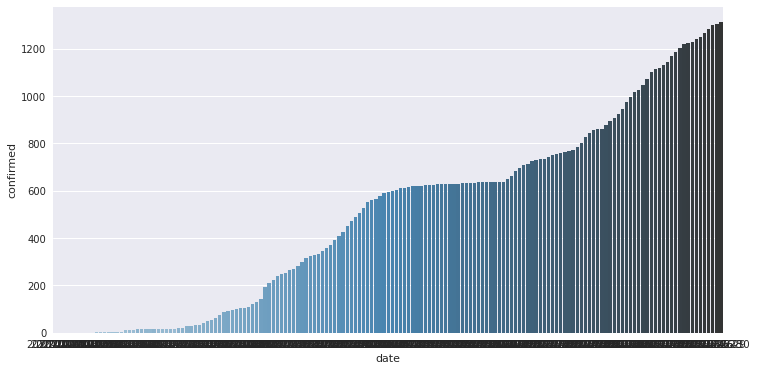

In [27]:
plt.figure(figsize=(12,6))
sample_data = province[province['province']== "서울"] # 경상북도에서의 확진자수 변화 확인  
pal = sns.color_palette("Blues_d", sample_data.shape[0]) 
rank = sample_data['confirmed'].argsort().argsort() # 이용량에 따라 색을 다르게해 시각화된 이미지의 직관성을 높입니다.
sns.barplot(x="date",y="confirmed",data=sample_data,palette=np.array(pal[::-1])[rank]) 
# plt.axvline(5.5,color='red',label='COIVD-19 era',linewidth=1)
#plt.axvspan(5.5, 9.5, color='red', alpha=0.2)
plt.legend()

No handles with labels found to put in legend.


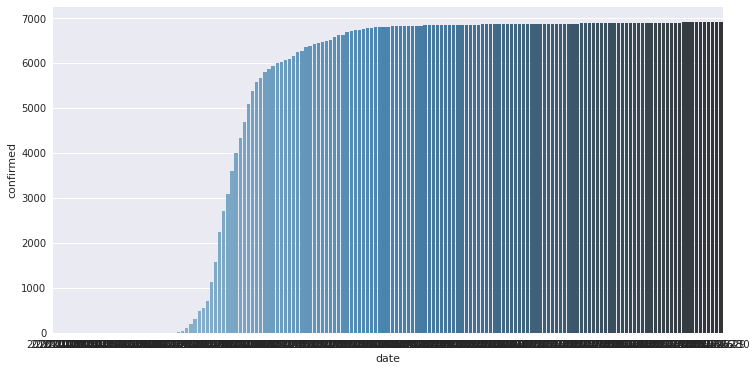

In [31]:
plt.figure(figsize=(12,6))
sample_data = province[province['province']== "대구"] # 경상북도에서의 확진자수 변화 확인  
pal = sns.color_palette("Blues_d", sample_data.shape[0]) 
rank = sample_data['confirmed'].argsort().argsort() # 이용량에 따라 색을 다르게해 시각화된 이미지의 직관성을 높입니다.
sns.barplot(x="date",y="confirmed",data=sample_data,palette=np.array(pal[::-1])[rank]) 
# plt.axvline(5.5,color='red',label='COIVD-19 era',linewidth=1)
#plt.axvspan(5.5, 9.5, color='red', alpha=0.2)
plt.legend()

In [38]:
# 시계열 데이터의 효율적인 클러스터링을 위한 normalization 진행
def normalization_axis(feature):
  sum_npy = np.array([x/np.sum(x) for x in feature])
  return sum_npy

In [43]:
import datetime
import collections
import folium

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

from tslearn.clustering import TimeSeriesKMeans

In [42]:
#!pip install tslearn

     |████████████████████████████████| 778kB 4.4MB/s 


In [48]:
# 필요한 데이터셋 구성
province.head()

# province 기준으로 확진자 데이터(confirmed) 묶어버리기, 날짜별로도 같이 묶기
province_df = province.loc[:, ['confirmed', 'time']]

In [73]:
# 각 지역별 clusting을 통한 위험군 나눔 
# random search 방법으로 n_cluster 지정 
n_cluster = 5
km = TimeSeriesKMeans(n_clusters=n_cluster, metric="euclidean", max_iter=150).fit(province_df) # normalization 시계열 데이터를 활용해 euclidean 기반 클러스터링을 진행합니다.
rlt_tsm = km.predict(province_df)

In [74]:
# 클러스터별 분포도를 시각화하기 위해 전처리 작업
labels = []
sizes = []
for i in range(n_cluster):
  labels.append("cluster_"+str(i))
  sizes.append(collections.Counter(rlt_tsm)[i])

([<matplotlib.patches.Wedge at 0x7ffadf3247b8>,
 [Text(-0.5349925698931005, -0.961136280742318, 'cluster_0'),
  Text(0.8524092228301998, 0.6952686652179968, 'cluster_1'),
  Text(0.5938463470624307, 0.9259300816371652, 'cluster_2'),
  Text(0.40201342821777725, 1.023906833424111, 'cluster_3'),
  Text(0.1996722976039189, 1.0817259234989112, 'cluster_4')],
 [Text(-0.29181412903260023, -0.5242561531321734, '83.8%'),
  Text(0.46495048518010895, 0.3792374537552709, '4.1%'),
  Text(0.3239161893067803, 0.5050527718020901, '6.0%'),
  Text(0.2192800517551512, 0.5584946364131514, '0.3%'),
  Text(0.1089121623294103, 0.590032321908497, '5.8%')])

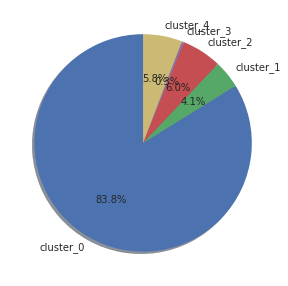

In [75]:
plt.figure(figsize=(10,5))
plt.pie(sizes,labels=labels,shadow=True,startangle=90,autopct='%1.1f%%')

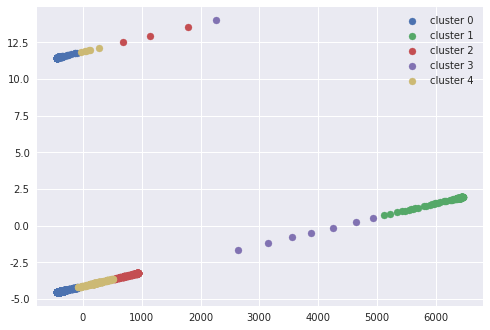

In [78]:
pca = PCA(n_components=2)  # pca를 진행해 클러스터가 얼마나 잘됐는지 검토합니다.
rlt_pca = pca.fit_transform(province_df[~np.isnan(province_df).any(axis=1)])
for i in range(n_cluster):
  label_name = "cluster " +str(i)
  plt.scatter(rlt_pca[[rlt_tsm==i]][:,0],rlt_pca[[rlt_tsm==i]][:,1],label=label_name)
plt.legend()

이제까지의 clustering은 기존의 확진자수 데이터를 기준으로 위험군 선정을 한 결과이나, 사실상 미래의 위험을 대비하기 위해서는 미래의 확진자를 기준으로 위험군 선정이 필요하므로, 확진자수를 먼저 예측한 이후에 다시 군집화(clustering)을 진행하여 위험군 선정하는 과정이 필요하다. 

### 4.2. 예측된 확진자수 데이터 기반으로 위험군 선정 

In [94]:
# 확진자수 예측을 위한 데이터
patientInfo_data = pd.read_csv('PatientInfo.csv')

In [97]:
patientInfo_data.head()

,patient_id,sex,age,country,province,city,infection_case,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,male,50s,Korea,서울,강서구,overseas inflow,NaN,75,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,male,30s,Korea,서울,중랑구,overseas inflow,NaN,31,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,male,50s,Korea,서울,종로구,contact with patient,2002000001,17,NaN,2020-01-30,2020-02-19,NaN,released
3,1000000004,male,20s,Korea,서울,마포구,overseas inflow,NaN,9,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,female,20s,Korea,서울,성북구,contact with patient,1000000002,2,NaN,2020-01-31,2020-02-24,NaN,released


In [93]:
# scaling 


In [90]:
# baseline model 


In [91]:
# hyperparameter tuning 


In [92]:
# visualization 
